# EMODnet data

### Specify server and protocol

We're going to download some data from the EMODnet portal. We'll start with tabledap data, which are timeseries like

In [1]:
from erddapy import ERDDAP
import json
import xarray as xr
import matplotlib.pyplot as plt

We will first use an arice dataset from the EMODnet ERDDAP

In [2]:
e = ERDDAP(
    server="https://erddap.emodnet-physics.eu/erddap",
    protocol="tabledap",
)

In [3]:
e.dataset_id="ARICE_de_pangaea_dataset326625"
ds_arice = e.to_xarray()

/home/callum/anaconda3/envs/erddapdemo/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'Visib' has multiple fill values {9.969209968386869e+36, 9999.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [4]:
ds_arice

<xarray.Dataset>
Dimensions:      (row: 3308)
Coordinates:
    altitude     (row) float64 ...
    time         (row) datetime64[ns] ...
    latitude     (row) float64 ...
    longitude    (row) float64 ...
Dimensions without coordinates: row
Data variables: (12/20)
    Ceil         (row) float32 ...
    Course       (row) float64 ...
    Bathy_depth  (row) float64 ...
    TdTdTd       (row) float64 ...
    Elevation    (row) float64 ...
    Head         (row) float64 ...
    ...           ...
    Visib        (row) float64 ...
    RelWindDir   (row) float64 ...
    dd           (row) float64 ...
    RelWindGust  (row) float64 ...
    RelWindSp    (row) float64 ...
    ff           (row) float64 ...
Attributes: (12/43)
    authors:                       König-Langlo, Gert
    cdm_data_type:                 Point
    citation:                      König-Langlo, Gert (2005): Continuous mete...
    contact:                       gert.koenig-langlo@awi.de
    Conventions:                   COARDS, CF-1.6, ACDD-1.3
    dataset:                       de.pangaea.dataset326625
    ...                            ...
    time_coverage_end:             2001-05-06T23:55:00Z
    time_coverage_start:           2001-04-14T00:05:00Z
    title:                         Continuous meteorological surface measurem...
    uuid:                          de.pangaea.dataset326625
    Westernmost_Easting:           -86.4635
    year:                          2005

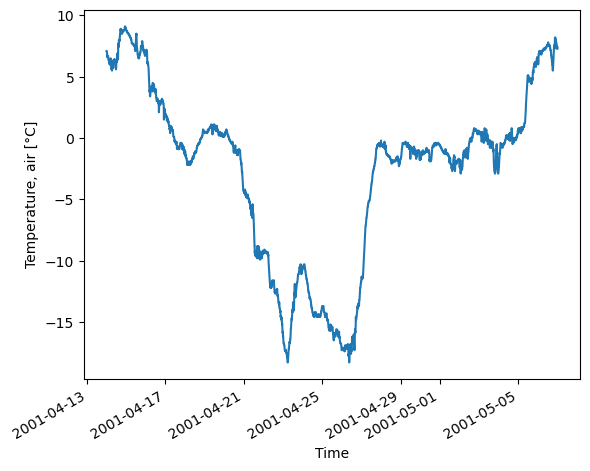

In [5]:
ds_arice.TTT.plot(x="time")

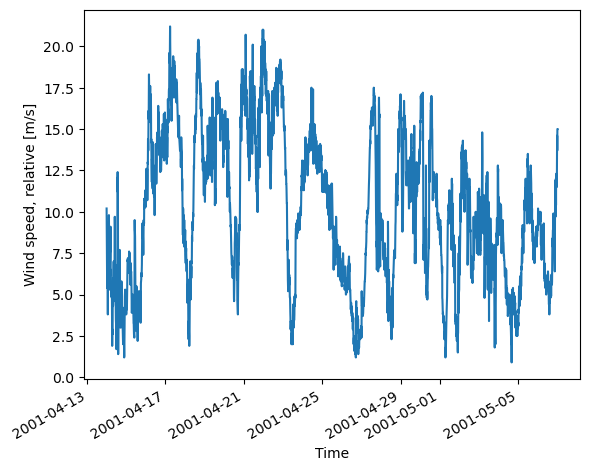

In [6]:
ds_arice.RelWindSp.plot(x="time")

### Gridded data

ERDDAP has a seperate mechanism for gridded data, like satellite and model/reanalysis products. This is called griddap

In [7]:
    response="opendap",


In [8]:
e = ERDDAP(
    server="https://erddap.emodnet-physics.eu/erddap",
    protocol="griddap",
)
e.dataset_id="SMOS_SSS_L3_V2020"

e.griddap_initialize()

print(f"variables in this dataset:\n\n{e.variables}")


variables in this dataset:

['uncertainty_sss', 'hr_sss', 'lr_sss']


In [9]:
ds_sss = e.to_xarray()

In [10]:
ds_sss

<xarray.Dataset>
Dimensions:          (time: 1, latitude: 720, longitude: 1440)
Coordinates:
  * time             (time) datetime64[ns] 2021-05-24T23:00:00
  * latitude         (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude        (longitude) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
Data variables:
    uncertainty_sss  (time, latitude, longitude) float32 ...
    hr_sss           (time, latitude, longitude) float32 ...
    lr_sss           (time, latitude, longitude) float32 ...
Attributes: (12/51)
    Acknowledgement:                           A complete description of the ...
    cdm_data_type:                             Grid
    comment:                                   These data were produced at BE...
    Conventions:                               CF-1.6, COARDS, ACDD-1.3
    copyright:                                 BEC research products are free...
    creator_email:                             olmedo@icm.csic.es
    ...                                        ...
    time_coverage_end:                         2021-05-24T23:00:00Z
    time_coverage_start:                       2021-05-24T23:00:00Z
    title:                                     SMOS BEC global SSS product v2...
    url:                                       http://bec.icm.csic.es
    Westernmost_Easting:                       -179.875
    wms_getcapabilities:                       https://erddap.emodnet-physics...

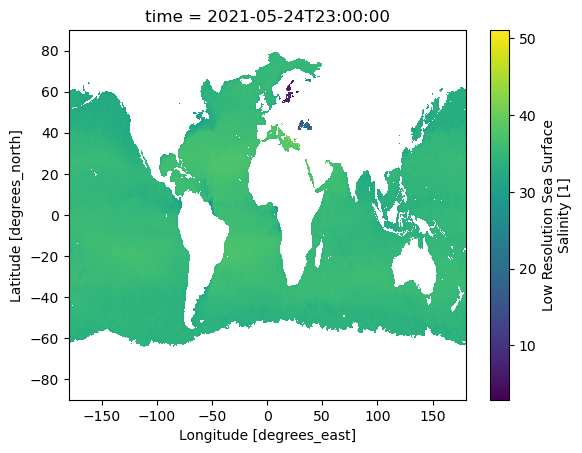

In [11]:
ds_sss.lr_sss.plot();

Gridded datasets can be very large. By default, erddapy returns only the most recent time slice of a dataset. This behaviour can be changed by adjusting the constraints.

Let's zoom in on the North Sea/Baltic and take a few time slices

In [12]:
e.constraints

{'time>=': '2021-05-24T23:00:00Z',
 'time<=': '2021-05-24T23:00:00Z',
 'time_step': 1,
 'latitude>=': -89.875,
 'latitude<=': 89.875,
 'latitude_step': 1,
 'longitude>=': -179.875,
 'longitude<=': 179.875,
 'longitude_step': 1}

To achieve this, we modify the constraints, tightening the lon/lat to a window of interest and requesting a wider timespan of data, taking every 30th day over the last few years

In [13]:
e.constraints = {'time>=': '2018-05-24T23:00:00Z',
 'time<=': '2021-05-24T23:00:00Z',
 'time_step': 30,
 'latitude>=': 50,
 'latitude<=': 70,
 'latitude_step': 1,
 'longitude>=': -10,
 'longitude<=': 30,
 'longitude_step': 1}

ds_sss_baltic = e.to_xarray()

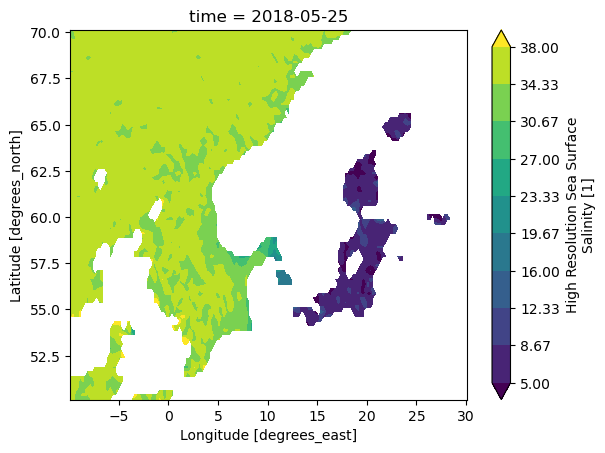

In [14]:
xr.plot.contourf(ds_sss_baltic.sel(time="'2018-06-01", method="nearest").hr_sss, vmin=5, vmax=38, levels=10);

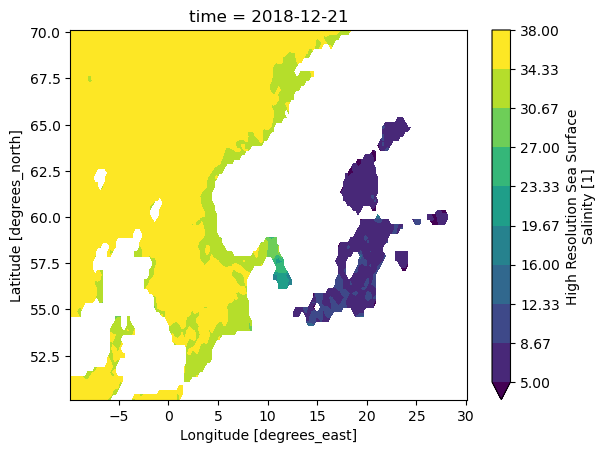

In [15]:
xr.plot.contourf(ds_sss_baltic.sel(time="'2019-01-01", method="nearest").hr_sss, vmin=5, vmax=38, levels=10);

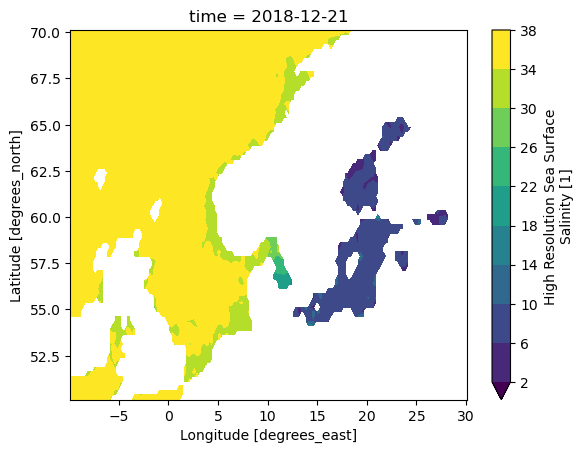

In [16]:
xr.plot.contourf(ds_sss_baltic.sel(time="'2019-01-01", method="nearest").hr_sss, vmin=2, vmax=38, levels=10);

----------------------------

### References

For more information on how erddapy deals with griddap, see the [erddapy documentation example notebook](https://ioos.github.io/erddapy/01a-griddap-output.html)